In [137]:
import numpy as np
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from keras import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.models import * 
from tensorflow.keras.preprocessing import image
from tensorflow import keras
from keras.models import Model
from tensorflow.keras import layers
from tensorflow.keras.utils import plot_model

In [138]:
import glob,os,cv2
hand_negative=glob.glob('/kaggle/input/mura-final/finaldata/train_final/XR_FOREARM/negative/*.png')
hand_positive=glob.glob('/kaggle/input/mura-final/finaldata/train_final/XR_FOREARM/positive/*.png')

hand_negative_t=glob.glob('/kaggle/input/mura-final/finaldata/valid_final/XR_FOREARM/negative/*.png')
hand_positive_t=glob.glob('/kaggle/input/mura-final/finaldata/valid_final/XR_FOREARM/positive/*.png')

In [139]:
data=[]
label=[]
ii=0
for i in hand_negative:
    while(ii<1500):
        a=cv2.imread(i,0)
        a=cv2.resize(a,(224,224))
        data.append(a)
        label.append(0)
        ii=ii+1
for i in hand_positive:
    a=cv2.imread(i,0)
    a=cv2.resize(a,(224,224))
    data.append(a)
    label.append(1)
for i in hand_negative_t:
        a=cv2.imread(i,0)
        a=cv2.resize(a,(224,224))
        data.append(a)
        label.append(0)
for i in hand_positive_t:
    a=cv2.imread(i,0)
    a=cv2.resize(a,(224,224))
    data.append(a)
    label.append(1)

In [140]:
data=np.array(data)
label=np.array(label)

In [141]:
from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test=train_test_split(data,label,stratify=label,test_size=0.2)

In [142]:
# Building the Xception Model Architecture

def entry_flow(inputs):

    x = layers.Conv2D(32, 3, strides=2, padding='same')(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)

    x = layers.Conv2D(64, 3, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)

    previous_block_activation = x  # Set aside residual
    
    # Blocks 1, 2, 3 are identical apart from the feature depth.
    for size in [128, 256, 728]:
        x = layers.Activation('relu')(x)
        x = layers.SeparableConv2D(size, 3, padding='same')(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation('relu')(x)
        x = layers.SeparableConv2D(size, 3, padding='same')(x)
        x = layers.BatchNormalization()(x)

        x = layers.MaxPooling2D(3, strides=2, padding='same')(x)

        residual = layers.Conv2D(  # Project residual
            size, 1, strides=2, padding='same')(previous_block_activation)           
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    return x

def middle_flow(x, num_blocks=8):
  
    previous_block_activation = x

    for _ in range(num_blocks):
        x = layers.Activation('relu')(x)
        x = layers.SeparableConv2D(728, 3, padding='same')(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation('relu')(x)
        x = layers.SeparableConv2D(728, 3, padding='same')(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation('relu')(x)
        x = layers.SeparableConv2D(728, 3, padding='same')(x)
        x = layers.BatchNormalization()(x)

        x = layers.add([x, previous_block_activation])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    return x


def exit_flow(x, num_classes=2):
  
    previous_block_activation = x

    x = layers.Activation('relu')(x)
    x = layers.SeparableConv2D(728, 3, padding='same')(x)
    x = layers.BatchNormalization()(x)

    x = layers.Activation('relu')(x)
    x = layers.SeparableConv2D(1024, 3, padding='same')(x)
    x = layers.BatchNormalization()(x)

    x = layers.MaxPooling2D(3, strides=2, padding='same')(x)

    residual = layers.Conv2D(  # Project residual
      1024, 1, strides=2, padding='same')(previous_block_activation)
    x = layers.add([x, residual])  # Add back residual

    x = layers.SeparableConv2D(1536, 3, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    
    x = layers.SeparableConv2D(2048, 3, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    
    x = layers.GlobalAveragePooling2D()(x)
    if num_classes == 1:
        activation = 'sigmoid'
    else:
        activation = 'softmax'
    return layers.Dense(num_classes, activation=activation)(x)

In [143]:
# Building the Xception Model Architecture

inputs = keras.Input(shape=(224, 224, 1))
outputs = exit_flow(middle_flow(entry_flow(inputs)))
model = keras.Model(inputs, outputs)

# Compiling the Model
model.compile(optimizer='adam', loss=keras.losses.sparse_categorical_crossentropy, metrics=['accuracy'])

# Checking Model Summary
model.summary()

Model: "functional_15"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_7       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_42 (Conv2D)  │ (None, 112, 112,  │        320 │ input_layer_7[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 112, 112,  │        128 │ conv2d_42[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_252      │ (None, 112, 112,  │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_43 (Conv2D)  │ (None, 112, 112,  │     18,496 │ activation_252[0… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 112, 112,  │        256 │ conv2d_43[0][0]   │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_253      │ (None, 112, 112,  │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_254      │ (None, 112, 112,  │          0 │ activation_253[0… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ separable_conv2d_2… │ (None, 112, 112,  │      8,896 │ activation_254[0… │
│ (SeparableConv2D)   │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 112, 112,  │        512 │ separable_conv2d… │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_255      │ (None, 112, 112,  │          0 │ batch_normalizat… │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ separable_conv2d_2… │ (None, 112, 112,  │     17,664 │ activation_255[0… │
│ (SeparableConv2D)   │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 112, 112,  │        512 │ separable_conv2d… │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_28    │ (None, 56, 56,    │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_44 (Conv2D)  │ (None, 56, 56,    │      8,320 │ activation_253[0… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_84 (Add)        │ (None, 56, 56,    │          0 │ max_pooling2d_28… │
│                     │ 128)              │            │ conv2d_44[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_256      │ (None, 56, 56,    │          0 │ add_84[0][0]    

 Total params: 20,883,722 (79.67 MB)

 Trainable params: 20,833,466 (79.47 MB)

 Non-trainable params: 50,256 (196.31 KB)

In [144]:
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy', 'precision', 'recall', 'auc'])


In [159]:
from keras.utils import to_categorical

# Convert the target data to binary labels
y_train_binary = to_categorical(y_train, num_classes=2)
y_test_binary = to_categorical(y_test, num_classes=2)

# Train the model using the binary labels
history = model.fit(
    x_train, y_train_binary,
    epochs=10,
    validation_data=(x_test, y_test_binary)
)


Epoch 1/10
62/62 ━━━━━━━━━━━━━━━━━━━━ 17s 268ms/step - accuracy: 0.9455 - auc: 0.9868 - loss: 0.1313 - precision: 0.9455 - recall: 0.9455 - val_accuracy: 0.9473 - val_auc: 0.9734 - val_loss: 0.1845 - val_precision: 0.9473 - val_recall: 0.9473
Epoch 2/10
62/62 ━━━━━━━━━━━━━━━━━━━━ 16s 266ms/step - accuracy: 0.9497 - auc: 0.9884 - loss: 0.1234 - precision: 0.9497 - recall: 0.9497 - val_accuracy: 0.9310 - val_auc: 0.9757 - val_loss: 0.1690 - val_precision: 0.9310 - val_recall: 0.9310
Epoch 3/10
62/62 ━━━━━━━━━━━━━━━━━━━━ 17s 267ms/step - accuracy: 0.9566 - auc: 0.9886 - loss: 0.1084 - precision: 0.9566 - recall: 0.9566 - val_accuracy: 0.9229 - val_auc: 0.9761 - val_loss: 0.1922 - val_precision: 0.9229 - val_recall: 0.9229
Epoch 4/10
62/62 ━━━━━━━━━━━━━━━━━━━━ 17s 267ms/step - accuracy: 0.9529 - auc: 0.9913 - loss: 0.0982 - precision: 0.9529 - recall: 0.9529 - val_accuracy: 0.8803 - val_auc: 0.9566 - val_loss: 0.2625 - val_precision: 0.8803 - val_recall: 0.8803
Epoch 5/10
62/62 ━━━━━━━━━━━

In [160]:
from tensorflow.keras.models import save_model

# Assuming you have your trained model in the variable 'model'

# Save the entire model (architecture, weights, and training configuration)
save_model(model, 'forearm_model.h5')  # Replace with your desired filename


In [161]:
# Convert the target data to binary labels
y_train_binary = to_categorical(y_train, num_classes=2)

# Evaluate the model using the binary labels
model.evaluate(x_train, y_train_binary)


62/62 ━━━━━━━━━━━━━━━━━━━━ 4s 67ms/step - accuracy: 0.9879 - auc: 0.9985 - loss: 0.0340 - precision: 0.9879 - recall: 0.9879


[0.04018945246934891,
 0.9837480783462524,
 0.9978636503219604,
 0.9837480783462524,
 0.9837480783462524]

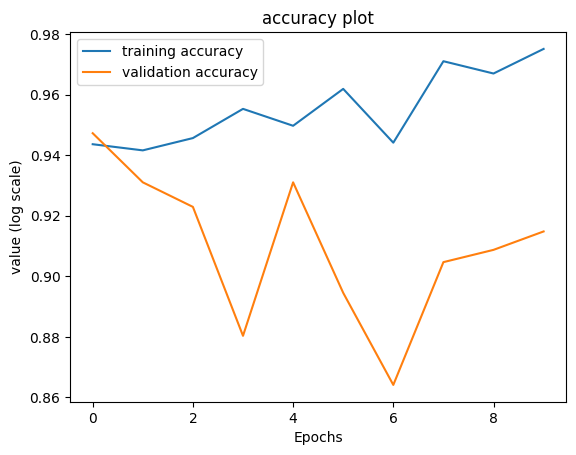

In [162]:
import matplotlib.pyplot as plt
plt.title('accuracy plot')
plt.plot(history.history['accuracy'],label='training accuracy')
plt.plot(history.history['val_accuracy'],label='validation accuracy')
plt.xlabel("Epochs")
plt.ylabel("value (log scale)")
plt.legend();

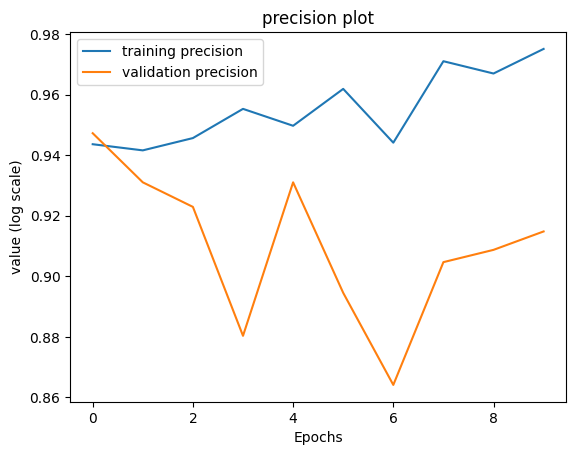

In [163]:
plt.title('precision plot')
plt.plot(history.history['precision'],label='training precision')
plt.plot(history.history['val_precision'],label='validation precision')
plt.xlabel("Epochs")
plt.ylabel("value (log scale)")
plt.legend();

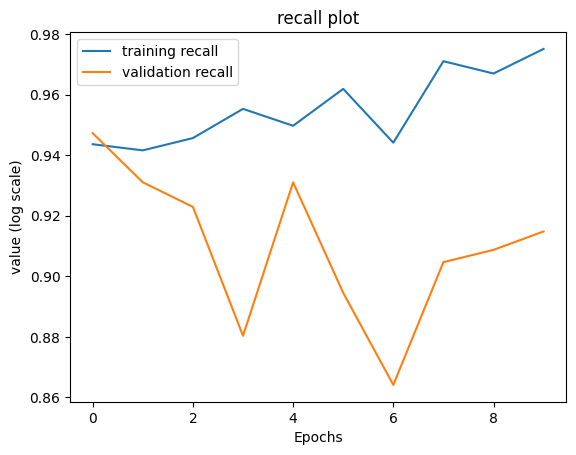

In [164]:
plt.title('recall plot')
plt.plot(history.history['recall'],label='training recall')
plt.plot(history.history['val_recall'],label='validation recall')
plt.xlabel("Epochs")
plt.ylabel("value (log scale)")
plt.legend();

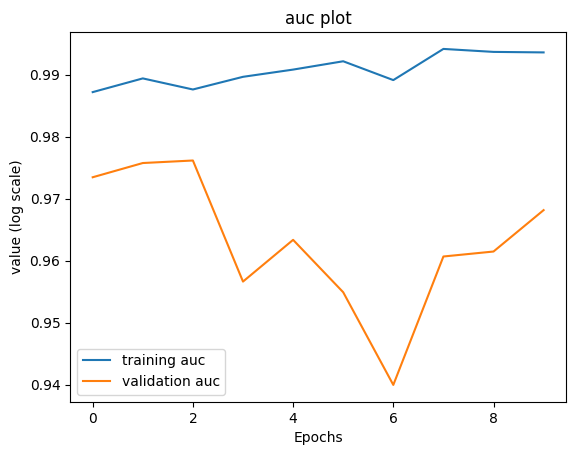

In [165]:
plt.title('auc plot')
plt.plot(history.history['auc'],label='training auc')
plt.plot(history.history['val_auc'],label='validation auc')
plt.xlabel("Epochs")
plt.ylabel("value (log scale)")
plt.legend();

In [166]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
train=model.predict(x_train)
val=model.predict(x_test)

62/62 ━━━━━━━━━━━━━━━━━━━━ 4s 60ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 60ms/step


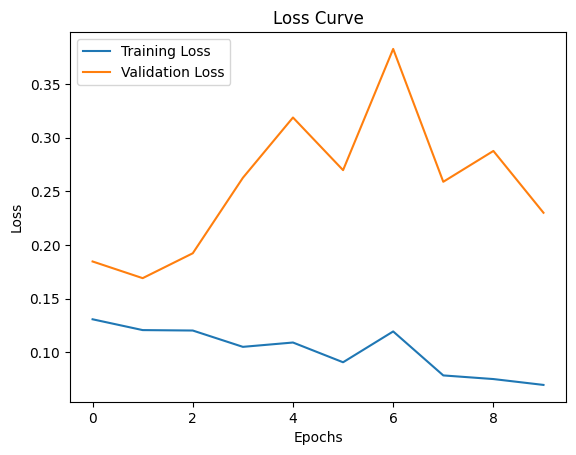

In [167]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Plot loss curve
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss Curve')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Generate confusion matrix
def plot_confusion_matrix(y_true, y_pred, labels):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.show()

# Convert probabilities to binary predictions
train_predictions = (train >= 0.5).astype(int)
val_predictions = (val >= 0.5).astype(int)



62/62 ━━━━━━━━━━━━━━━━━━━━ 4s 60ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 60ms/step


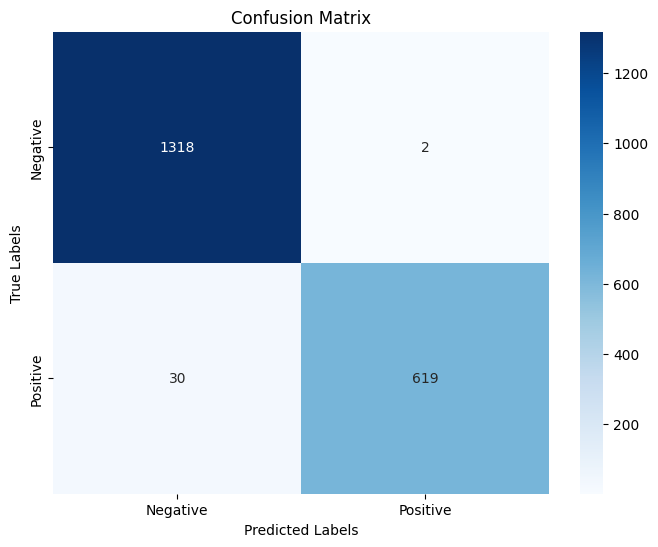

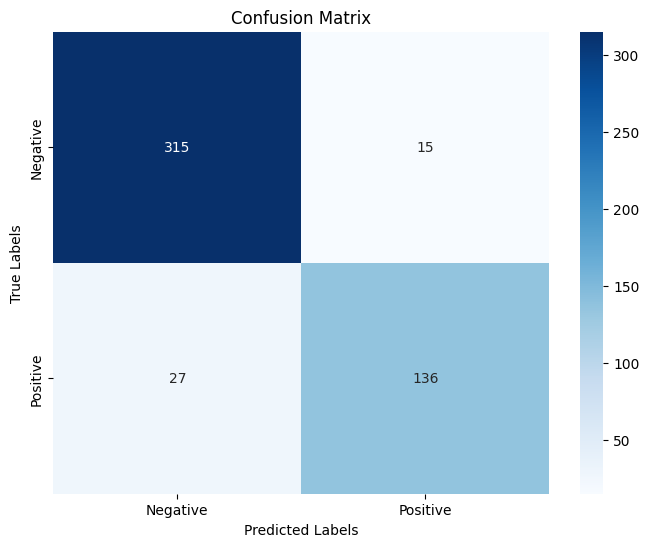

In [168]:
def plot_confusion_matrix(y_true, y_pred, labels):
    cm = confusion_matrix(y_true.argmax(axis=1), y_pred.argmax(axis=1))
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.show()

# Generating predictions for training and validation
train_predictions = model.predict(x_train)
val_predictions = model.predict(x_test)

# Convert probabilities to binary predictions using argmax to select the class with the highest probability
plot_confusion_matrix(y_train_binary, train_predictions, ['Negative','Positive'])
plot_confusion_matrix(y_test_binary, val_predictions, ['Negative','Positive'])

In [155]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Convert probabilities to binary predictions
train_predictions = (train >= 0.5).astype(int)

# Calculate the confusion matrix
conf_matrix_train = confusion_matrix(y_train, train_predictions)

# Plot the confusion matrix
sns.heatmap(conf_matrix_train, annot=True)


ValueError: Classification metrics can't handle a mix of binary and multilabel-indicator targets

In [ ]:
sns.heatmap(confusion_matrix(val,y_test),annot=True)

In [ ]:
print(classification_report(train,y_train))

In [ ]:
print(classification_report(val,y_test))